In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 5)


In [2]:
# === Input data (edit if you have updated figures) ===
data = {
    'Range_Height': list(range(1, 25)),
    'APR_pct': [
        266.94, 133.83, 92.16, 68.73, 54.83, 46.32, 39.59, 34.59,
        30.71, 27.63, 25.12, 23.03, 21.26, 19.76, 18.57, 17.32,
        16.36, 15.44, 14.64, 13.93, 13.26, 12.73, 12.14, 11.66
    ],
    'Rebalance_Count': [
        2390, 1044, 576, 408, 281, 200, 153, 116,
        108, 86, 68, 55, 50, 47, 45, 38,
        33, 29, 29, 26, 18, 18, 19, 18
    ]
}
df = pd.DataFrame(data)
df.head()


,Range_Height,APR_pct,Rebalance_Count
0,1,266.94,2390
1,2,133.83,1044
2,3,92.16,576
3,4,68.73,408
4,5,54.83,281


In [3]:
# === Composite score parameters ===
weights = dict(APR=1/3, REB=1/3, HEIGHT=1/3)  # modify as you like

# Normalise metrics
df['APR_norm'] = (df['APR_pct'] - df['APR_pct'].min()) / (df['APR_pct'].max() - df['APR_pct'].min())
df['REB_norm'] = (df['Rebalance_Count'].max() - df['Rebalance_Count']) / (df['Rebalance_Count'].max() - df['Rebalance_Count'].min())
df['HEIGHT_norm'] = (df['Range_Height'].max() - df['Range_Height']) / (df['Range_Height'].max() - df['Range_Height'].min())

df['Composite_Score'] = (
    weights['APR']   * df['APR_norm'] +
    weights['REB']   * df['REB_norm'] +
    weights['HEIGHT']* df['HEIGHT_norm']
)

df.sort_values('Composite_Score', ascending=False).head(10)


,Range_Height,APR_pct,Rebalance_Count,APR_norm,REB_norm,HEIGHT_norm,Composite_Score
1,2,133.83,1044,0.478573,0.567454,0.956522,0.667516
0,1,266.94,2390,1.000000,0.000000,1.000000,0.666667
2,3,92.16,576,0.315340,0.764755,0.913043,0.664380
3,4,68.73,408,0.223558,0.835582,0.869565,0.642902
4,5,54.83,281,0.169108,0.889123,0.826087,0.628106
5,6,46.32,200,0.135772,0.923272,0.782609,0.613884
6,7,39.59,153,0.109409,0.943086,0.739130,0.597209
7,8,34.59,116,0.089823,0.958685,0.695652,0.581387
8,9,30.71,108,0.074624,0.962057,0.652174,0.562952
9,10,27.63,86,0.062559,0.971332,0.608696,0.547529


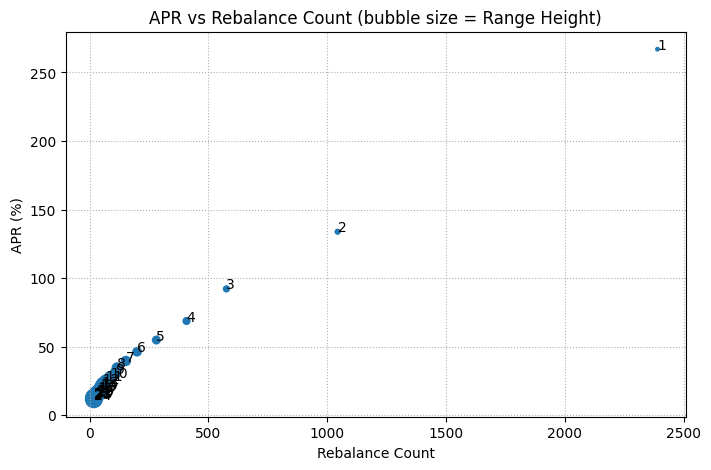

In [4]:
# === Visualise APR vs Rebalance count ===
plt.scatter(df['Rebalance_Count'], df['APR_pct'], s=df['Range_Height']*6)
plt.xlabel("Rebalance Count")
plt.ylabel("APR (%)")
plt.title("APR vs Rebalance Count (bubble size = Range Height)")
for _, row in df.iterrows():
    plt.annotate(int(row['Range_Height']), (row['Rebalance_Count'], row['APR_pct']))
plt.grid(True, linestyle=':')
plt.show()


In [5]:
# === Gas assumptions (Arbitrum) ===
gas_used_per_rebalance = 700_000      # gas
gas_price_gwei = 0.10                 # gwei
eth_price_usd = 3000                  # USD

cost_per_rebalance_usd = gas_used_per_rebalance * gas_price_gwei * 1e-9 * eth_price_usd
print(f"Cost per rebalance ≈ ${cost_per_rebalance_usd:,.3f}")

# Capital sizes (edit or extend)
capitals = [1_000, 10_000, 50_000]

for cap in capitals:
    df[f'Net_APR_@${cap//1000}k'] = df['APR_pct'] - (df['Rebalance_Count'] * cost_per_rebalance_usd / cap * 100)

df[['Range_Height', 'APR_pct', 'Rebalance_Count'] + [c for c in df.columns if c.startswith('Net_APR')]].head(10)


Cost per rebalance ≈ $0.210


,Range_Height,APR_pct,Rebalance_Count,Net_APR_@$1k,Net_APR_@$10k,Net_APR_@$50k
0,1,266.94,2390,216.750,261.9210,265.93620
1,2,133.83,1044,111.906,131.6376,133.39152
2,3,92.16,576,80.064,90.9504,91.91808
3,4,68.73,408,60.162,67.8732,68.55864
4,5,54.83,281,48.929,54.2399,54.71198
5,6,46.32,200,42.120,45.9000,46.23600
6,7,39.59,153,36.377,39.2687,39.52574
7,8,34.59,116,32.154,34.3464,34.54128
8,9,30.71,108,28.442,30.4832,30.66464
9,10,27.63,86,25.824,27.4494,27.59388


In [6]:
def evaluate(weights=None, gas_price_gwei=0.10, eth_price=3000, capitals=(10_000, )):
    """Recompute the composite & net APRs with custom weights, gas, and capital sizes."""
    w = weights or dict(APR=1/3, REB=1/3, HEIGHT=1/3)
    # Re‑use global df but make a copy for safety
    d = df.copy()
    d['Composite_Score'] = (
        w['APR']   * d['APR_norm'] +
        w['REB']   * d['REB_norm'] +
        w['HEIGHT']* d['HEIGHT_norm']
    )
    cost_reb = gas_used_per_rebalance * gas_price_gwei * 1e-9 * eth_price
    for cap in capitals:
        d[f'Net_APR_@${cap//1000}k'] = d['APR_pct'] - (d['Rebalance_Count'] * cost_reb / cap * 100)
    return d.sort_values('Composite_Score', ascending=False)

# Example: heavier weight on APR
evaluate(weights=dict(APR=0.5, REB=0.3, HEIGHT=0.2)).head()


,Range_Height,APR_pct,Rebalance_Count,APR_norm,REB_norm,HEIGHT_norm,Composite_Score,Net_APR_@$1k,Net_APR_@$10k,Net_APR_@$50k
0,1,266.94,2390,1.000000,0.000000,1.000000,0.700000,216.750,261.9210,265.93620
1,2,133.83,1044,0.478573,0.567454,0.956522,0.600827,111.906,131.6376,133.39152
2,3,92.16,576,0.315340,0.764755,0.913043,0.569705,80.064,90.9504,91.91808
3,4,68.73,408,0.223558,0.835582,0.869565,0.536367,60.162,67.8732,68.55864
4,5,54.83,281,0.169108,0.889123,0.826087,0.516509,48.929,54.2399,54.71198
